## Prediction
Upload models in sequence, append their predictions in sequence, and then evaluate required results

1. [done] Deterministic write pipeline for producing df w [mean, std, actual]
2. [done] Train ensemble
3. Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
4. Produce plot showing the selective prediction w uncertainty thresholding
5. Produce plot showing histology slide with companion aleatoric, epistemic, and total

In [35]:
from pathlib import Path
from anndata import read_h5ad
import sys
import scanpy
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
# stimage custom 
file = Path("../stimage").resolve() # path to src code
parent = file.parent
sys.path.append(str(parent))

from tqdm import tqdm

from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator

In [37]:
import pickle

In [6]:
DATA_PATH = Path("/scratch/smp/uqsmac12/dataset_breast_cancer_9visium")

OUT_PATH = Path("/scratch/smp/uqsmac12/results")

OUT_PATH.mkdir(parents=True, exist_ok=True)

In [7]:
(DATA_PATH / "all_adata.h5ad").exists()

True

In [9]:
os.listdir(OUT_PATH)

['resnet50_3.h5',
 'resnet50_9.h5',
 'resnet50_2.h5',
 'resnet50_8.h5',
 'resnet50_4.h5',
 'resnet50_6.h5',
 'resnet50_10.h5',
 'resnet50_0.h5',
 'resnet50_5.h5',
 'resnet50_7.h5',
 'resnet50_1.h5']

In [10]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

The annadata object `adata_all` contains STexpression readings for each spot (represented in a spotXexpression matrix). The bellow script accesses cell attribute information and updates the path.

In [11]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        "/scratch/smp/uqsmac12/dataset_breast_cancer_9visium"))

In [12]:
adata_all.obs["tile_path"][0]

'/scratch/smp/uqsmac12/dataset_breast_cancer_9visium/tiles/1142243F-12601-4511-299.jpeg'

In [13]:
gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

['COX6C',
 'TTLL12',
 'PABPC1',
 'GNAS',
 'HSP90AB1',
 'TFF3',
 'ATP1A1',
 'B2M',
 'FASN',
 'SPARC',
 'CD74',
 'CD63',
 'CD24',
 'CD81']

In [14]:
# remove FFPE and 1160920F --- the test set
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())]

In [15]:
n_genes = len(gene_list)

training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "FFPE"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [16]:
train_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

In [25]:
devices = tf.config.list_physical_devices("GPU")
if len(devices) > 0:
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [31]:
def get_samples_stats_geneid(np_preds, list_genes):
    """
    """
    res = []
    for gene_idx, gene_name in enumerate(list_genes):
        
        # predicted NB params 
        n, p = np_preds[gene_idx][:,0], np_preds[gene_idx][:,1]
        # mean, var
        mu, var = nbinom.stats(n, p, moments='mv')
        
        res.append(np.stack([n, p, mu, var], axis=1))
        
    return np.stack(res, axis=2)

## Get results from ensembles

In [36]:
ensemble_results1 = []
ensemble_results2 = []

for e_id in tqdm(range(10)):
    e_id += 1
    print(f"Ensemble id {e_id}")
    # load model
    model = None
    file_model = str(OUT_PATH / f'resnet50_{e_id}.h5')
    model = load_model(file_model, 
                       custom_objects={
                           'negative_binomial_loss': negative_binomial_loss,
                       }
                      )
    print("loaded")
    # get predictions 
    pred_test_1 = model.predict(test_gen__1)
    print("got preds1")
    pred_test_2 = model.predict(test_gen__2)
    print("got preds2")
    # append results 
    ensemble_results1.append(get_samples_stats_geneid(pred_test_1, gene_list))
    ensemble_results2.append(get_samples_stats_geneid(pred_test_2, gene_list))
    print("appended results")
    
ensemble_results1 = np.stack(ensemble_results1, axis=3)
ensemble_results2 = np.stack(ensemble_results2, axis=3)

  0%|          | 0/10 [00:00<?, ?it/s]

Ensemble id 1
loaded
got preds1


 10%|█         | 1/10 [02:12<19:50, 132.32s/it]

got preds2
appended results
Ensemble id 2
loaded
got preds1


 20%|██        | 2/10 [04:28<17:58, 134.77s/it]

got preds2
appended results
Ensemble id 3
loaded
got preds1


 30%|███       | 3/10 [06:37<15:24, 132.05s/it]

got preds2
appended results
Ensemble id 4
loaded
got preds1


 40%|████      | 4/10 [08:49<13:12, 132.11s/it]

got preds2
appended results
Ensemble id 5
loaded
got preds1


 50%|█████     | 5/10 [11:05<11:07, 133.54s/it]

got preds2
appended results
Ensemble id 6
loaded
got preds1


 60%|██████    | 6/10 [13:11<08:43, 130.95s/it]

got preds2
appended results
Ensemble id 7
loaded
got preds1


 70%|███████   | 7/10 [15:23<06:33, 131.27s/it]

got preds2
appended results
Ensemble id 8
loaded
got preds1


 80%|████████  | 8/10 [17:38<04:24, 132.30s/it]

got preds2
appended results
Ensemble id 9
loaded
got preds1


 90%|█████████ | 9/10 [19:46<02:11, 131.02s/it]

got preds2
appended results
Ensemble id 10
loaded
got preds1


100%|██████████| 10/10 [21:53<00:00, 131.39s/it]

got preds2
appended results


In [38]:
with open(str(OUT_PATH / 'ensemble_results_1.pkl'), 'wb') as file:
    pickle.dump(ensemble_results1, file)
    
with open(str(OUT_PATH / 'ensemble_results_2.pkl'), 'wb') as file:
    pickle.dump(ensemble_results2, file)

# FFPE

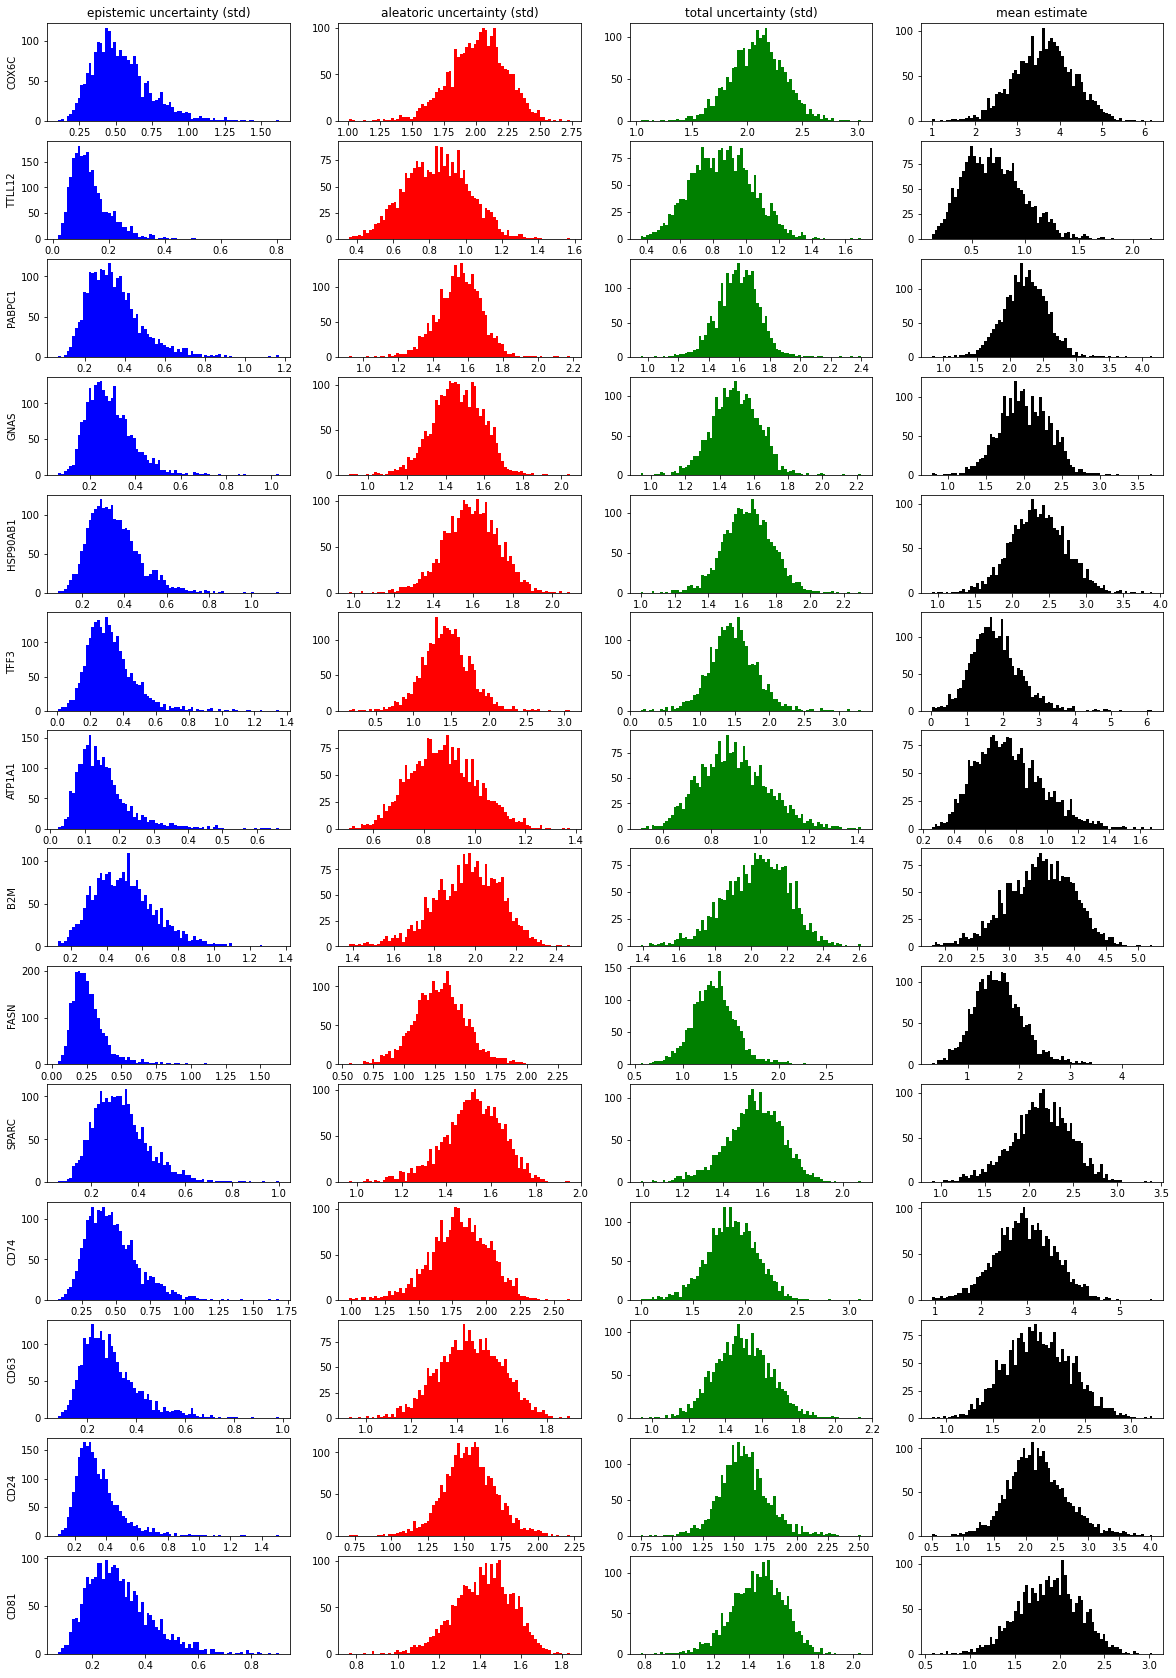

In [59]:
mean = ensemble_results1[:,-2:,:,:].mean(axis=-1)
var = ensemble_results1[:,-2:,:,:].var(axis=-1)

# E(mean), V(mean), E(var), total
np_total_var = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)

fig, ax = plt.subplots(nrows=len(gene_list), ncols=4, figsize=(20, 30))

ax[0][0].set_title("epistemic uncertainty (std)")
ax[0][1].set_title("aleatoric uncertainty (std)")
ax[0][2].set_title("total uncertainty (std)")
ax[0][3].set_title("mean estimate")

for gid, gname in enumerate(gene_list):
    ax[gid][0].set_ylabel(gname)
    ax[gid][0].hist(np.sqrt(np_total_var[:,1,gid]), bins=80, color='b')
    ax[gid][1].hist(np.sqrt(np_total_var[:,2,gid]), bins=80, color='r')
    ax[gid][2].hist(np.sqrt(np_total_var[:,3,gid]), bins=80, color='g')
    ax[gid][3].hist(np_total_var[:,0,gid], bins=80, color='k')

fig.show()

# 1160920F

In [60]:
mean = ensemble_results2[:,-2:,:,:].mean(axis=-1)
var = ensemble_results2[:,-2:,:,:].var(axis=-1)

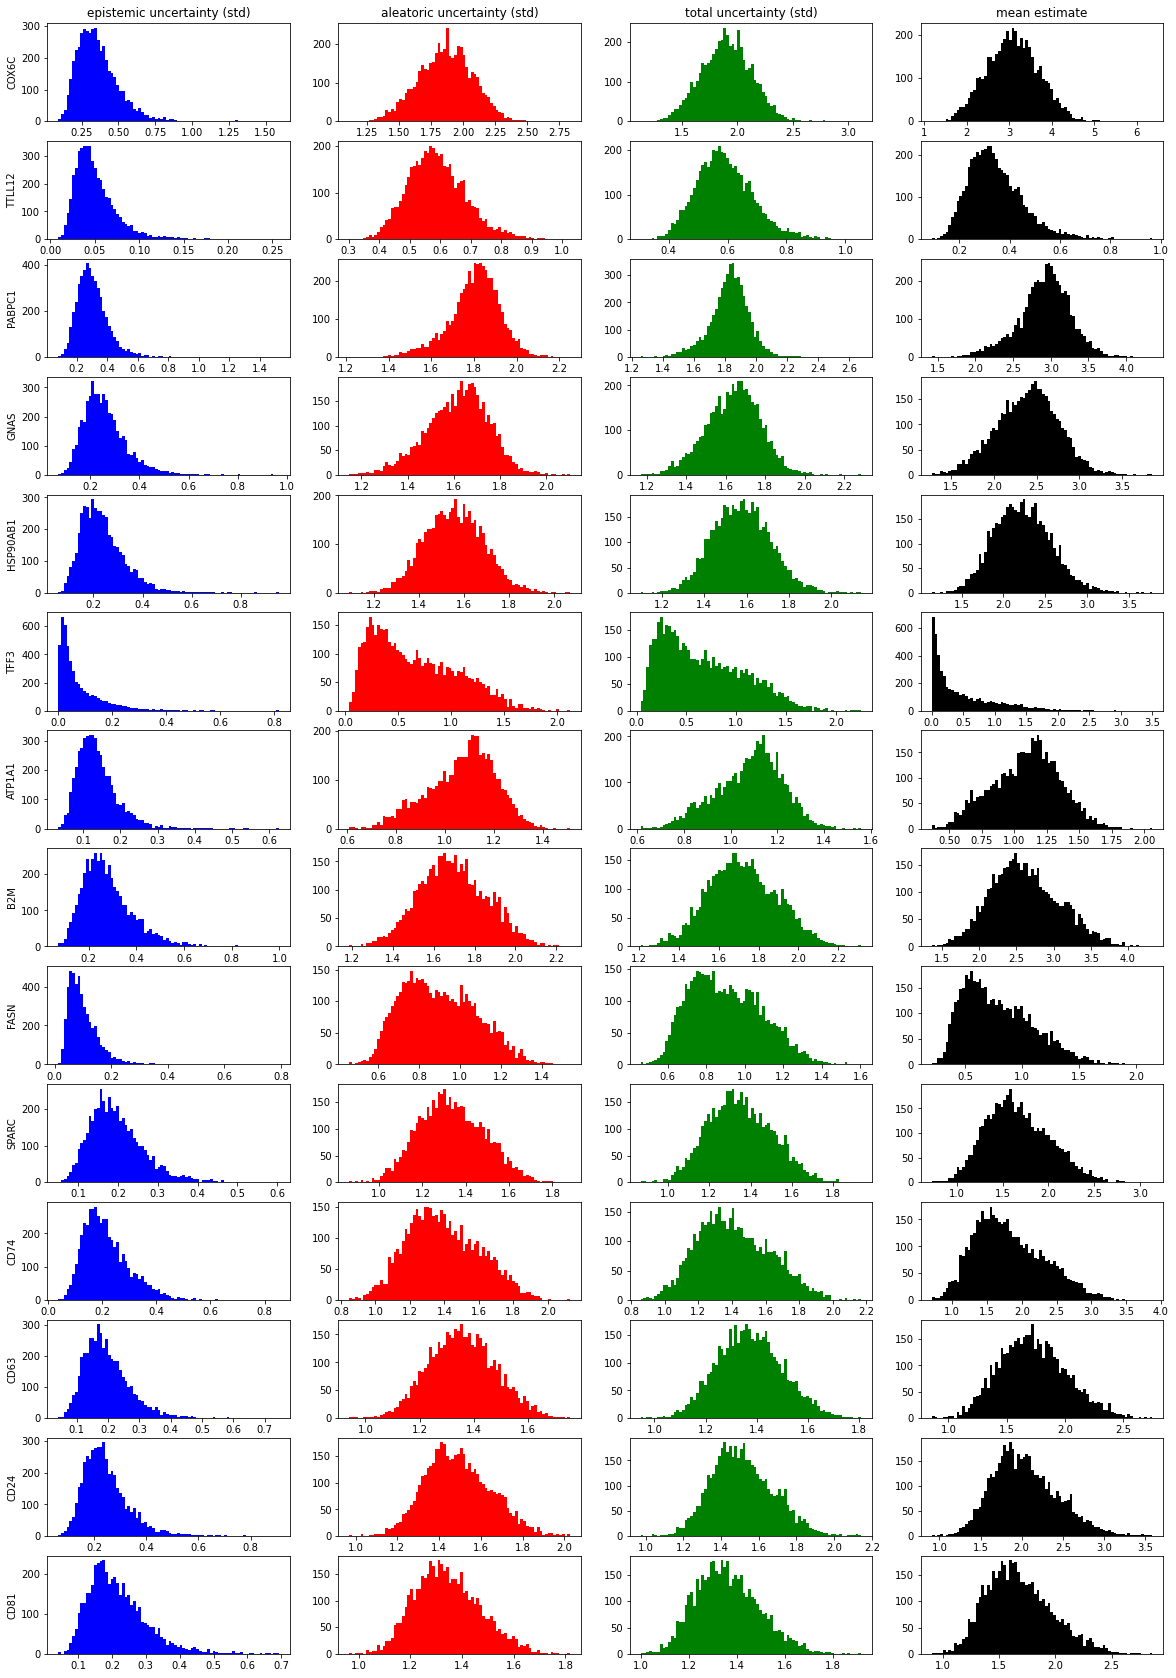

In [58]:
# E(mean), V(mean), E(var), total
np_total_var = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)

fig, ax = plt.subplots(nrows=len(gene_list), ncols=4, figsize=(20, 30))

ax[0][0].set_title("epistemic uncertainty (std)")
ax[0][1].set_title("aleatoric uncertainty (std)")
ax[0][2].set_title("total uncertainty (std)")
ax[0][3].set_title("mean estimate")

for gid, gname in enumerate(gene_list):
    ax[gid][0].set_ylabel(gname)
    ax[gid][0].hist(np.sqrt(np_total_var[:,1,gid]), bins=80, color='b')
    ax[gid][1].hist(np.sqrt(np_total_var[:,2,gid]), bins=80, color='r')
    ax[gid][2].hist(np.sqrt(np_total_var[:,3,gid]), bins=80, color='g')
    ax[gid][3].hist(np_total_var[:,0,gid], bins=80, color='k')

fig.show()

In [45]:
np_total_var

(2338, 3, 14)

In [28]:
# get predictions 
pred_test_1 = model.predict(test_gen__1)
pred_test_2 = model.predict(test_gen__2)

In [30]:
pred_test_1[0].shape

(2338, 2)

In [ ]:
pred_test_1.shape

In [27]:
# ground truth / target information
df_target_1 = test_dataset_1.to_df().loc[:, gene_list]
df_target_2 = test_dataset_2.to_df().loc[:, gene_list]

In [32]:
res = get_samples_stats_geneid(pred_test_1, gene_list)

In [33]:
res.shape

(2338, 4, 14)

In [114]:
def get_results(df_target, np_preds, list_genes):
    
    # instantiate dictionary
    dict_results = {}
    
    for gene_idx, gene_name in enumerate(list_genes):
        
        # actual 
        target = df_target[gene_name]

        # predicted NB params 
        n, p = np_preds[gene_idx][:,0], np_preds[gene_idx][:,1]
        
        # mean, var, std 
        mu, var = nbinom.stats(n, p, moments='mv')
        std = np.sqrt(var)

        # create dataframe
        df_temp = pd.DataFrame(
            data=np.stack([mu, var, std, target], axis=1), 
            columns=['mean', 'var', 'std', 'target'],
            index= df_target.index
        )
        
        # append dictionary
        dict_results[gene_name] = df_temp
        
    return dict_results

In [135]:
tf.random.set_seed()

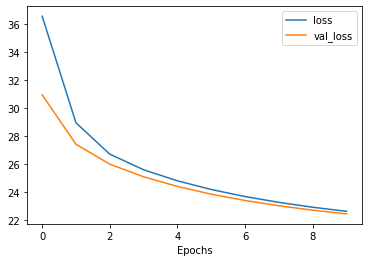

In [22]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [34]:
test_dataset_1??

In [45]:
# TO DO

# 1. deterministic write pipeline for producing df w [mean, std, actual]
# 1.5. train ensemble
# 2. Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
# 3. produce plot showing the selective prediction w uncertainty thresholding
# 4. produce plot showing histology slide with companion aleatoric, epistemic, and total

# 
# Draft results by end of week 2 (Feb-17th)

(2338, 14)

In [ ]:
test_dataset_1

In [89]:
df_temp.head()

,mean,var,std,target
0,2.935439,4.074678,2.018583,2.944439
1,5.838997,11.633478,3.410788,1.098612
2,7.910624,17.247154,4.152969,2.079442
3,4.063245,6.980574,2.642078,1.098612
4,4.097795,6.987684,2.643423,0.693147


In [98]:
df_target = df_target_1.copy()
np_preds = pred_test_1.copy()
list_genes = gene_list.copy()

In [107]:
dict_res1 = get_results(
    df_target = df_target_1, 
    np_preds = pred_test_1,
    list_genes = gene_list
)

In [115]:
dict_res2 = get_results(
    df_target = df_target_2, 
    np_preds = pred_test_2,
    list_genes = gene_list
)

In [128]:
df_res1_all = pd.concat([dict_res1[g] for g in dict_res1.keys()], axis=0)
df_res2_all = pd.concat([dict_res2[g] for g in dict_res2.keys()], axis=0)

In [129]:
df_res_all = pd.concat([df_res1_all, df_res2_all], axis=0)

In [131]:
pearsonr(df_res1_all['target'], df_res1_all['mean'])

(0.2762159394096582, 0.0)

In [132]:
pearsonr(df_res2_all['target'], df_res2_all['mean'])

(0.5736514250260873, 0.0)

In [130]:
pearsonr(df_res_all['target'], df_res_all['mean'])

(0.4494130066977668, 0.0)

In [121]:
pearsonr(dict_res2['COX6C']['mean'], dict_res2['COX6C']['target'])

(-0.1027875138788497, 1.0353204570941155e-12)

In [117]:
dict_res2['COX6C'].head()

,mean,var,std,target
TGGTACCGGCACAGCC-1-1160920F,3.259137,5.483247,2.341633,0.000000
GCGCGTTTAAATCGTA-1-1160920F,2.897606,4.424093,2.103353,0.693147
TGCCTTGCCCTTACGG-1-1160920F,4.820837,9.262687,3.043466,1.098612
GACGACTTTCCAAGAA-1-1160920F,3.893397,6.666375,2.581932,1.791759
CCAGTGAGCTCCTTGT-1-1160920F,1.962099,2.708454,1.645738,0.000000
